In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data/shoulder_right_train_10_17.log',
#              './training_data_old/shoulder_right_data_6.log',
#              './training_data_old/shoulder_right_data_7.log',
#              './training_data_old/shoulder_right_data_8.log',
#              './training_data_old/shoulder_right_data_9.log',
#             ]

body_part = "shoulder_left"
file_names = [
    './training_data/val_fb_sfast_dvbf_medium.bag'
#     './training_data/val_fb_fast_gt.csv'
]

# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
abnormal_threshold = 0.5
dataset = []
orig_dataset = []

euler_idxs = ["position_0", "position_1", "position_2"]
# action_idxs = ["cf_velocity_0", "cf_velocity_1", "cf_velocity_2"]
action_idxs = ["target_position_0", "target_position_1", "target_position_2"]
magnetic_idxs = [f'{coord}_{id}' for id in range(4) for coord in ['x','y','z']]

for name in file_names:
    df = pd.read_csv(name, header=0)
    
#     df['date'] = pd.to_datetime(df.Time, unit='s')
#     df.groupby(pd.Grouper(key='date', freq='20L')).mean().interpolate()

    orig_dataset.append(df.copy())
    
    # interpolate nan outputs (loss tracking)
    for c in euler_idxs:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
#     for c in magnetic_idxs:
#         bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
#         df.loc[bad_idx, c] = np.nan
#         df[c] = df[c].interpolate()
    
#     # Add action
#     for c in df.columns[-3:]:
#         df["dt"] = (df["Time"][1:].tolist() - df["Time"][:-1])
#         df[c + "_u"] = (df[c][1:].tolist() - df[c][:-1]) / df["dt"]
    
#     # Remove last row
#     df = df[:-1]
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 
orig_dataset = pd.concat(orig_dataset)

print(f'{np.sum(dataset_len)} values')

dataset = dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]
orig_dataset = orig_dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]

# dataset = dataset[abs(dataset[:,12])!=0.0,:]
# dataset = dataset[abs(dataset[:,13])!=0.0,:]
# dataset = dataset[abs(dataset[:,14])!=0.0,:]

# print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
action_set = dataset[:, 15:]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

15047 values
max euler 0.4048930652052869
min euler -2.039221058094067


In [4]:
len(orig_dataset), len(dataset)

(15047, 15047)

In [5]:
dataset_len

[15047]

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [7]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [8]:
# model_path = f"./outputs_idp/local_{body_part}_dvbf_long_trajs_ad_with_target_rot6D"
model_path = f"./outputs_idp_isrr/{body_part}_dvbf_long_trajs_no_ad_with_target_rot6D"

sensors_scaler, action_scaler = joblib.load(f'{model_path}/scaler.pkl')

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)
action_set = action_scaler.transform(action_set)

In [9]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [10]:
look_back = 10

data_in = []
data_u = []
data_hat_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(orig_sensors_set[i:i+look_back])
        data_hat_in.append(sensors_set[i:i+look_back])
        data_u.append(action_set[i:i+look_back])
        data_out.append(rot_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

15027


In [11]:
with open(f'{model_path}/hyperparams.json', 'r') as fp:
    p = json.load(fp)

In [12]:

dm = SensorsDataModule(
    data_x = data_in,
#     data_x = data_hat_in,
    data_u = data_u,
    data_y = data_out,
    data_x_hat = data_hat_in,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [13]:
# model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best-epoch=9889-val_loss=-233.49173.ckpt")
model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best-alpha=30.0-reg=0.01.ckpt")

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [14]:
# device = "cuda"
device = "cpu"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=64, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=35, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=1)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models): 

In [15]:
sen_in = orig_sensors_set[None]
in_set = torch.tensor(sen_in, dtype=torch.float32).to(device)
u_set = torch.tensor(action_set[None], dtype=torch.float32).to(device)
# u_set *= 0.0
out_set, meas_mean_set, meas_var_set = model.predict(in_set, u_set, True)
out_set = out_set[0]
rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

In [16]:
test_euler_set = dataset[:, 12:15]
time_arr = np.arange(len(test_euler_set))#[9500:11000]#[6500:7500]
plt_prefix = "ts_9k5-11k"

euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred).cpu().detach().numpy()[time_arr]
euler_gt = torch.tensor(test_euler_set, dtype=torch.float32).to(device).cpu().detach().numpy()[time_arr]

In [17]:
plt.rc('font', size=18)

<IPython.core.display.Javascript object>


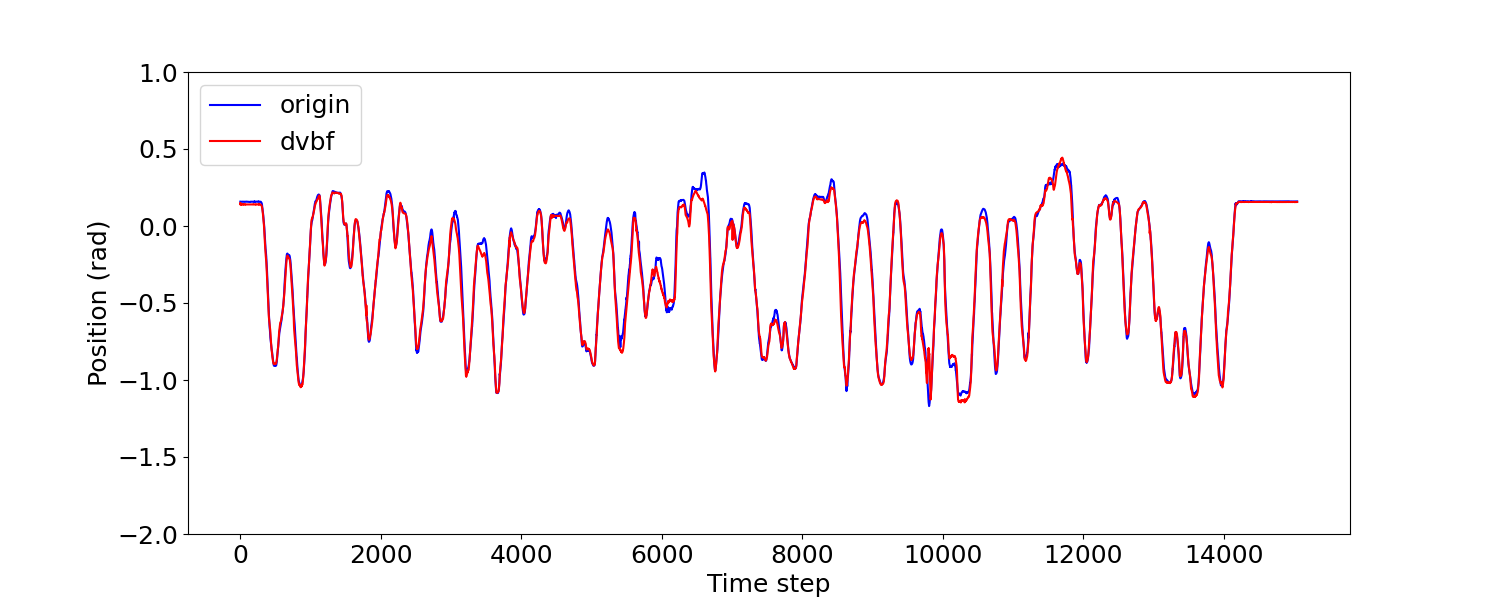

In [18]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 0], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 0], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_0.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


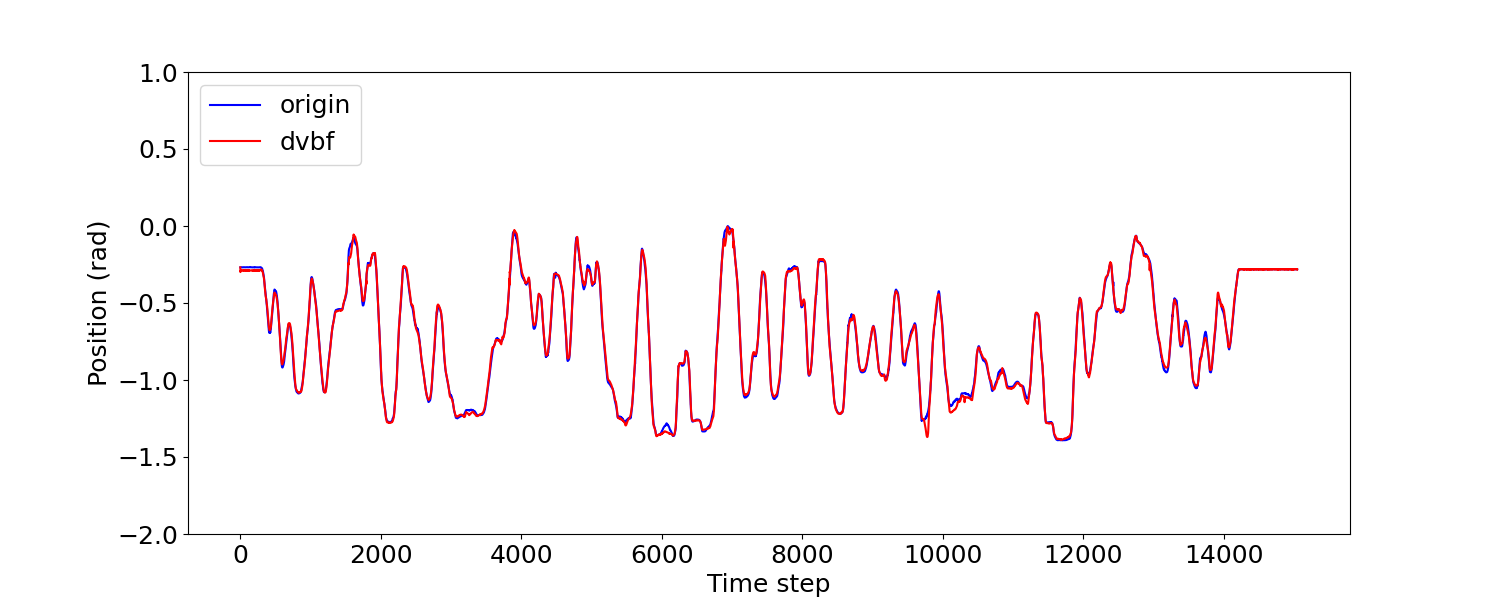

In [19]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 1], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 1], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_1.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


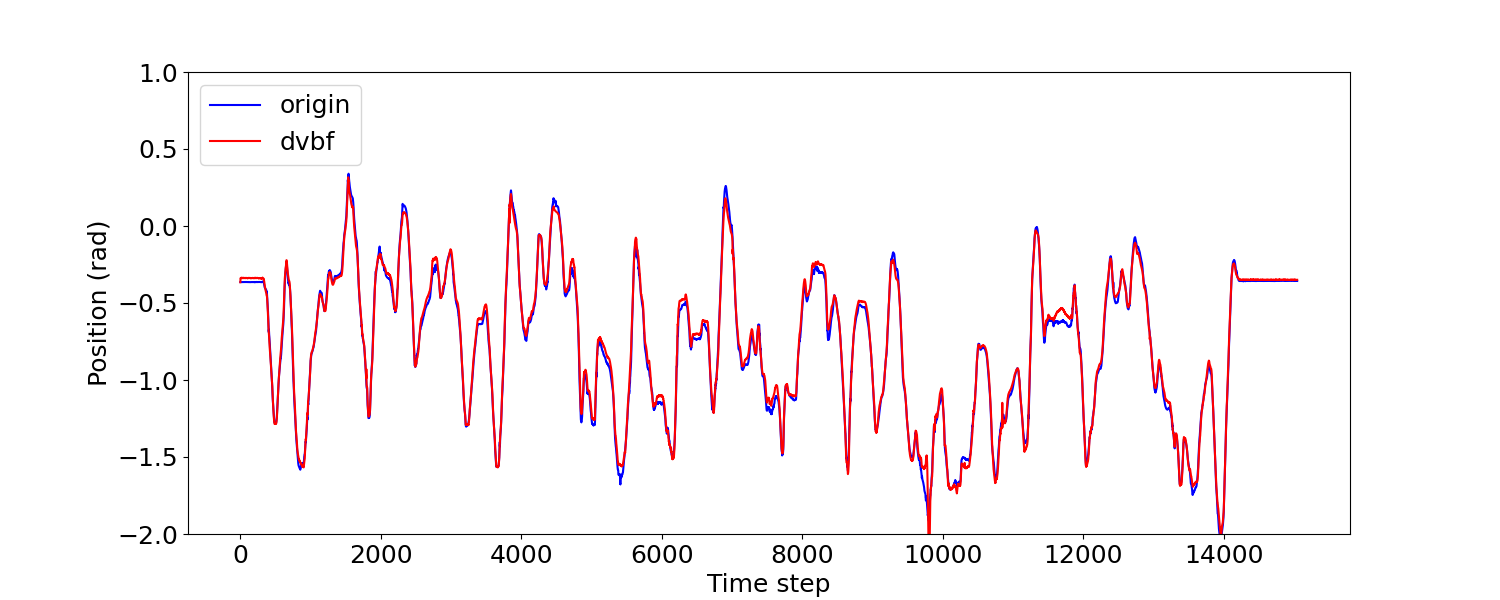

In [20]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 2], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 2], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_2.pdf', dpi=100, bbox_inches='tight')

# Analysis at jumpy area

In [21]:
np.set_printoptions(precision=5, suppress=True)

## Timestep 7k

In [22]:
mag = sen_in[0, :, 1][time_arr]
mag[7020:7025, :]

array([[-0.21204,  0.41098,  0.28588],
       [-0.21486,  0.41477,  0.28588],
       [ 0.01834, -0.59091,  0.47094],
       [-0.21862,  0.42614,  0.2847 ],
       [-0.2205 ,  0.42614,  0.28588]])

In [23]:
torch.stack(meas_mean_set[7020:7025], dim=0).detach().numpy().shape

(5, 1, 4, 32)

In [24]:
torch.stack(meas_mean_set[7020:7025], dim=0).detach().numpy()[:, 0, 1]

array([[ 0.77222,  0.72722,  1.15492,  0.26667, -1.65205, -0.16112,
         0.49572,  0.45016,  1.89022,  0.61833, -0.4511 , -0.56834,
         0.44674, -0.37591, -0.2971 , -0.31642,  0.07255,  1.01651,
         0.857  ,  0.16659,  0.43902,  3.47704,  0.1814 ,  1.16234,
         1.09907, -0.53953, -3.57078, -0.46189,  1.13152, -1.06111,
         3.1874 , -0.53947],
       [ 0.77655,  0.72364,  1.16101,  0.26614, -1.66746, -0.15898,
         0.49929,  0.45342,  1.88546,  0.61467, -0.4531 , -0.56987,
         0.44758, -0.38617, -0.28838, -0.31863,  0.07545,  1.01899,
         0.85911,  0.17209,  0.44281,  3.48868,  0.17954,  1.16071,
         1.10616, -0.54707, -3.58639, -0.46676,  1.13076, -1.06224,
         3.1956 , -0.54801],
       [ 1.64258,  1.36894,  0.62444, -0.14175, -1.6034 , -0.50379,
         0.00715,  0.99254,  2.09774,  0.65274, -0.78378, -0.07484,
         0.32676,  1.30961, -1.17011, -0.50953, -0.65356,  1.81634,
         0.61432, -0.64676,  0.53454,  2.38417, -0.64163, 

In [25]:
1/torch.stack(meas_var_set[7020:7025], dim=0).detach().numpy()[:, 0, 1].sum(axis=1)

array([0.94055, 0.94054, 0.43788, 0.94368, 0.94252], dtype=float32)

In [26]:
1/torch.stack(meas_var_set[7020:7025], dim=0).detach().numpy()[0, 0, :].sum(axis=1)

array([0.67989, 0.94055, 0.18418, 0.5273 ], dtype=float32)

## TImestep 10k

In [27]:
# idxs = slice(10309, 10314)
idxs = slice(10847, 10860)
# idxs = slice(11580, 11590)

In [28]:
mag = sen_in[0, :, 2]
mag[idxs, :]

array([[-0.10635,  0.69205, -0.19086],
       [-0.26396,  0.46854, -0.08215],
       [-0.09946,  0.69536, -0.20198],
       [-0.0987 ,  0.69702, -0.20692],
       [-0.0964 ,  0.69868, -0.21186],
       [-0.09487,  0.70033, -0.21557],
       [-0.09181,  0.70199, -0.22298],
       [-0.09028,  0.70364, -0.22792],
       [-0.08722,  0.7053 , -0.23533],
       [-0.08416,  0.70199, -0.23904],
       [-0.0811 ,  0.70695, -0.24645],
       [-0.07804,  0.71026, -0.25139],
       [-0.07345,  0.71192, -0.25757]])

In [29]:
torch.stack(meas_mean_set[idxs], dim=0).detach().numpy()[:, 0, 2]

array([[ 0.25715, -1.41528, -0.03804, -0.4465 ,  0.22537, -0.9359 ,
         0.71683, -0.71074,  1.69278, -0.85484,  1.0809 , -2.95594,
        -1.10228, -0.0652 , -3.02448, -0.21264,  0.30411, -1.52172,
        -0.24329,  0.54397,  0.82304, -0.36488,  0.11911,  0.95944,
         0.09987,  2.08407,  0.59073, -0.1694 ,  0.08857, -3.75858,
         0.00155, -3.58253],
       [ 0.14362, -1.10366,  0.04946, -0.56603,  0.08541, -0.40005,
         0.44491, -0.1439 ,  1.01133, -0.44648,  0.44302, -2.20143,
        -0.70902, -0.17204, -2.19588, -0.25792,  0.3083 , -1.10616,
        -0.07041,  0.41445,  0.63585, -0.05058, -0.2555 ,  1.31977,
         0.33667,  1.23528,  0.04242, -0.08635, -0.06259, -2.91212,
         0.00688, -3.09245],
       [ 0.25273, -1.45696, -0.0389 , -0.44049,  0.23142, -0.93465,
         0.73995, -0.71445,  1.71427, -0.88573,  1.09219, -2.96131,
        -1.09204, -0.07882, -3.02201, -0.18982,  0.3254 , -1.55791,
        -0.27561,  0.52488,  0.81127, -0.37819,  0.11408, 

In [30]:
1/torch.stack(meas_var_set[idxs], dim=0).detach().numpy()[:, 0, 2].sum(axis=1)

array([0.13021, 0.17879, 0.12826, 0.12767, 0.12688, 0.12627, 0.12525,
       0.12457, 0.12356, 0.12335, 0.12196, 0.12091, 0.11981],
      dtype=float32)

In [31]:
1/torch.stack(meas_var_set[idxs], dim=0).detach().numpy()[2, 0, :].sum(axis=1)

array([0.56349, 0.87306, 0.12826, 0.0741 ], dtype=float32)